### Obesity - Classification (Semester B)


In [38]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
#from bokeh.plotting import figure, output_file, show
#from bokeh.palettes import magma
import matplotlib.cm as cm 
#import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix



np.set_printoptions(precision=5)

In [4]:
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
df.head(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight



* Gender : Male or Female
* Age : Age of the person
* Height : Height in "meter"
* Weight : Weight in "kilogram"
* family_history_with_overweight : if parents/family with obesity
* FAVC : Frequent consumption of high caloric food
* FCVC : Frequency of consumption of vegetables
* NCP : Number of main meals (per day)
* CAEC : Consumption of food between meals
* SMOKE : does the person smoke or not
* CH2O : Consumption of water daily
* SCC : Calories consumption monitoring
* FAF : Physical activity frequency (per week)
* TUE : Time using technology devices
* CALC : Alcool consumption
* MTRANS : what kind of transportation taken
* NObeyesdad : level of obesity


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [6]:
#Other than 'Age', 'Weight' and 'Height' there is no reason for the other numeric columns to be 'float'. We'll change it.
columns = ["NCP", "CH2O", "TUE", "FAF","FCVC"]
for col in columns:
    df[col] = df[col].astype('int64')

Last semester, our best model received an accuracy of 82%. When we presented the confusion matrix of this model,<br> we saw that sometimes the model predicts illogical things.<br>
For example, the model consistently predicted person with normal weight as obese type II or type III.

We will check if there is a direct connection between people who are defined as normal weight and people who are defined as obese type II or type III.<br> 
Accordingly, we will remove columns that may have confused our models in the previous semester.<br>

We will try to achieve better accuracy in our models, also by using other models and other techniques. 

In [7]:
Normal_Weight = df.loc[df.NObeyesdad == "Normal_Weight"]
Obesity_Type_II = df.loc[df.NObeyesdad == "Obesity_Type_II"]
Obesity_Type_III = df.loc[df.NObeyesdad == "Obesity_Type_III"]

frames = [Normal_Weight,Obesity_Type_II,Obesity_Type_III]
result = pd.concat(frames)

<AxesSubplot:xlabel='MTRANS', ylabel='Count'>

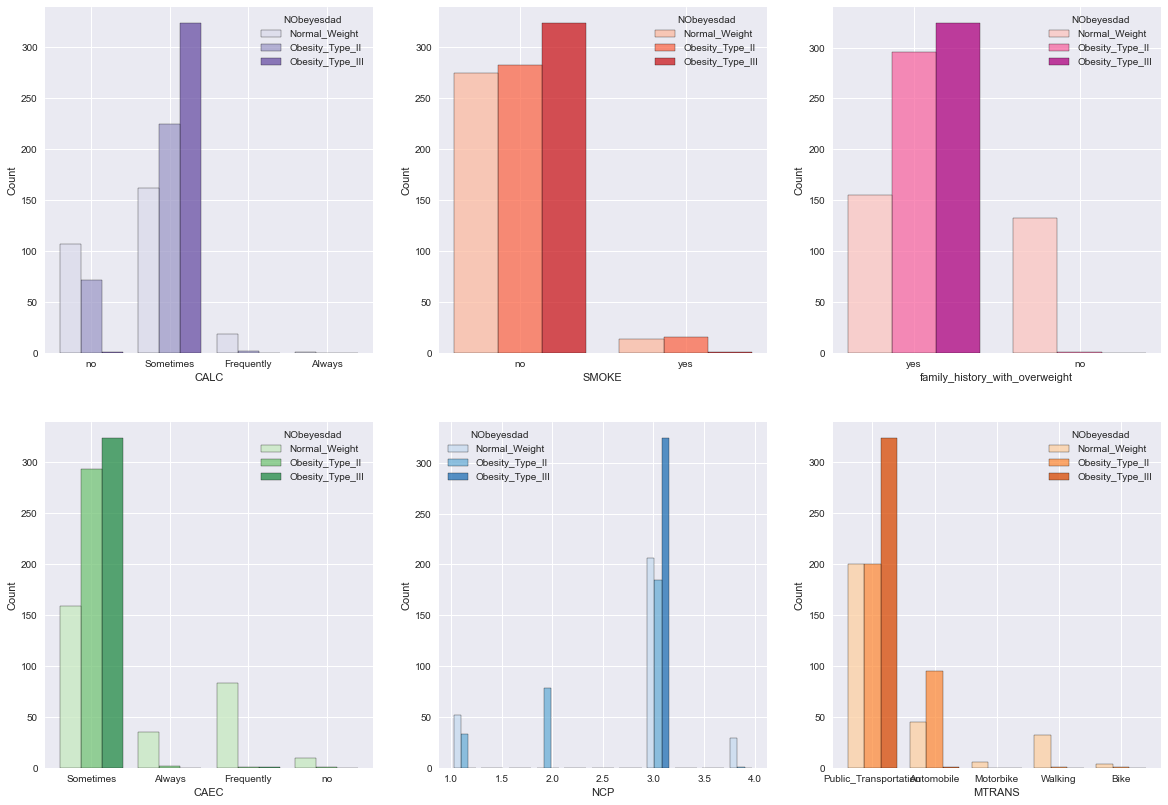

In [8]:
fig, axs = plt.subplots(ncols=3, nrows = 2,figsize = (20,14))

sns.histplot(data=result, x="CALC", hue="NObeyesdad", multiple="dodge", shrink=.8,palette="Purples",ax=axs[0][0])
sns.histplot(data=result, x="SMOKE", hue="NObeyesdad", multiple="dodge", shrink=.8,palette="Reds",ax=axs[0][1])
sns.histplot(data=result, x="family_history_with_overweight", hue="NObeyesdad", multiple="dodge", shrink=.8,palette="RdPu",ax=axs[0][2])
sns.histplot(data=result, x="CAEC", hue="NObeyesdad", multiple="dodge", shrink=.8,palette="Greens",ax=axs[1][0])
sns.histplot(data=result, x="NCP", hue="NObeyesdad", multiple="dodge", shrink=.8,palette="Blues",ax=axs[1][1])
sns.histplot(data=result, x="MTRANS", hue="NObeyesdad", multiple="dodge", shrink=.8,palette="Oranges",ax=axs[1][2])


In [18]:
pd.DataFrame(result.NObeyesdad.groupby(result.MTRANS).value_counts())

NObeyesdad
MTRANS                NObeyesdad                  
Automobile            Obesity_Type_II           95
                      Normal_Weight             45
                      Obesity_Type_III           1
Bike                  Normal_Weight              4
                      Obesity_Type_II            1
Motorbike             Normal_Weight              6
Public_Transportation Obesity_Type_III         323
                      Normal_Weight            200
                      Obesity_Type_II          200
Walking               Normal_Weight             32
                      Obesity_Type_II            1

In [19]:
Normal = Normal_Weight.describe(include='O').iloc[2:4]
Type_II =Obesity_Type_II.describe(include='O').iloc[2:4]
Type_III =Obesity_Type_III.describe(include='O').iloc[2:4]

In [20]:
Normal

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
top,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Normal_Weight
freq,146,155,208,159,274,257,161,200,287


In [21]:
Type_II

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
top,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_II
freq,295,296,290,293,282,296,224,200,297


In [22]:
Type_III

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,323,324,323,323,323,324,323,323,324


In [23]:
df_res = df.copy(deep=True)
df_res = pd.get_dummies(df, columns=['Gender','FAVC','family_history_with_overweight','CAEC',
                                     'SCC','FCVC','CH2O','FAF','SMOKE','TUE','CALC'])

In [24]:
#dropping 'Weight' colmn
df_res.drop(columns=['Weight','MTRANS'],inplace=True)

In [25]:
from sklearn.model_selection import train_test_split

X = df_res.drop(columns=["NObeyesdad"])
y = df_res['NObeyesdad'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

In [27]:
#split the train
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

##  Models:

* LGBMClassifier
* Random Forest
* XGBClassifier
* VotingClassifier

In [29]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_predict = dummy_clf.predict(X_val)
print("The DummyClassifier score is:" ,round(dummy_clf.score(y_predict,y_val),3))

The DummyClassifier score is: 0.157


### *LGBMClassifier:*

In [32]:
lgb = lgb.LGBMClassifier()
lgb.fit(X_train, y_train)
y_predict = lgb.predict(X_val)

accuracy = metrics.accuracy_score(y_predict,y_val)
print("Accuracy:",round(accuracy,3))

Accuracy: 0.855


#### RandomForestClassifier

In [33]:
RF = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_predict = RF.predict(X_val)
accuracy = round(metrics.accuracy_score(y_predict,y_val),3)
print("Accuracy:",accuracy)

Accuracy: 0.828


##### XGBClassifier

In [34]:
XGBClassifier = XGBClassifier(objective="binary:logistic", random_state=42,num_class=7)
XGBClassifier.fit(X_train,y_train,eval_metric='auc')
y_predict = XGBClassifier.predict(X_val)
accuracy = accuracy_score(y_predict,y_val)
round(accuracy,3)

0.849

#### VotingClassifier:

In [39]:
LGB = lgb.LGBMClassifier()
DecisionTree = DecisionTreeClassifier()
LogisticRegression = LogisticRegression()
KNN = KNeighborsClassifier()
RandomForest = RandomForestClassifier()
XGB = XGBClassifier(objective="binary:logistic",num_class=7,eval_metric='auc')

voting_clf = VotingClassifier(estimators=[('LGB', LGB),('XGB', XGB),('RandomForest',RandomForest),('DecisionTree',DecisionTree)
                                          ,('LogisticRegression', LogisticRegression), ('KNN', KNN)
                                          ],voting='soft',weights=[4,4,1,0,0,0])
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('LGB', LGBMClassifier()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric='auc', gamma=None,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child...
                                            predictor=None, random_state=None,
                                            reg_alp

In [40]:
for clf in (LGB, XGB, RandomForest, DecisionTree, LogisticRegression, KNN, voting_clf):
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_val)
    print(clf.__class__.__name__, round(accuracy_score(y_val, y_predict),3))

LGBMClassifier 0.855
XGBClassifier 0.849
RandomForestClassifier 0.822
DecisionTreeClassifier 0.749
LogisticRegression 0.58
KNeighborsClassifier 0.689
VotingClassifier 0.867


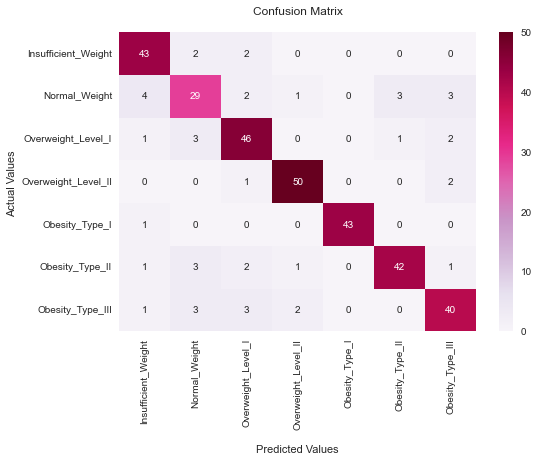

In [41]:
labels = ['Insufficient_Weight','Normal_Weight', 'Overweight_Level_I'
          ,'Overweight_Level_II','Obesity_Type_I','Obesity_Type_II','Obesity_Type_III']
cf_matrix = confusion_matrix(y_val, y_predict)
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='PuRd')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(labels,rotation=90)
ax.yaxis.set_ticklabels(labels,rotation=0)
plt.show()

*Our best model is VotingClassifier.*<br> *Run the full data:*


In [42]:
X_train = np.concatenate((X_train,X_val),axis=0)
y_train = np.concatenate((y_train,y_val),axis=0)

In [43]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('LGB', LGBMClassifier()),
                             ('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False,
                                            eval_metric='auc', gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, mi...
                                            objective='multi:softprob',
                                            predictor='au

In [45]:
for clf in (LGB, XGB, RandomForest, DecisionTree, LogisticRegression, KNN, voting_clf):
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    print(clf.__class__.__name__, round(accuracy_score(y_test, y_predict),3))

LGBMClassifier 0.842
XGBClassifier 0.865
RandomForestClassifier 0.858
DecisionTreeClassifier 0.764
LogisticRegression 0.589
KNeighborsClassifier 0.757
VotingClassifier 0.863


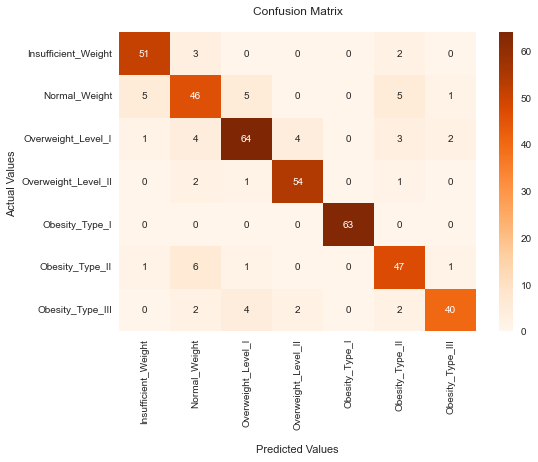

In [68]:
cf_matrix = confusion_matrix(y_test, y_predict)
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Oranges')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(labels,rotation=90)
ax.yaxis.set_ticklabels(labels,rotation=0)
plt.show()

### Best accuracy -  VotingClassifier 0.863

<b>In conclusion, by re-looking at the data and using more powerful models,<br> we improved the accuracy percentages from 0.82% to 0.86 (-:<b/>